In [33]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectKBest, mutual_info_classif

## Data Preprocessing

In [34]:
def load_data():
    # Load metadata with labels
    train_metadata_df = pd.read_csv('train/train_metadata.csv')
    test_metadata_df = pd.read_csv('test/test_metadata.csv')
    
    # Load all feature files
    feature_files = [
        'shape_features.csv',
        'texture_features.csv',
        'hog_pca.csv',
        'color_histogram.csv',
        'additional_features.csv'
    ]
    
    train_feature_dfs = {}
    test_feature_dfs = {}
    
    for file in feature_files:
        train_file_path = os.path.join('train/Features', file)
        test_file_path = os.path.join('test/Features', file)

        train_feature_dfs[file] = pd.read_csv(train_file_path)
        test_feature_dfs[file] = pd.read_csv(test_file_path)
    
    return train_metadata_df, test_metadata_df, train_feature_dfs, test_feature_dfs

In [35]:
def merge_data(metadata_df, feature_dfs):
	# Merge multiple feature dataframes on image_path
    merged_feature_df = None

    for _, feature_df in feature_dfs.items():
        if merged_feature_df is None:
            merged_feature_df = feature_df.copy()
        else:
            feature_cols = [col for col in feature_df.columns if col != 'image_path']
            merged_feature_df = pd.merge(merged_feature_df, feature_df[['image_path'] + feature_cols], on='image_path', how='inner')
    
	# Merge features with labels
    merged_df = pd.merge(merged_feature_df, metadata_df[["image_path", "ClassId"]], on='image_path', how='inner')
    
    return merged_df

In [36]:
def preprocess_data():
    train_metadata_df, test_metadata_df, train_feature_dfs, test_feature_dfs = load_data()

    merged_df = merge_data(train_metadata_df, train_feature_dfs)
    test_df = merge_data(test_metadata_df, test_feature_dfs)

    # Split data
    y = merged_df['ClassId']
    train_df, val_df, y_train, y_val = train_test_split(
        merged_df, y, test_size=0.2, random_state=42, stratify=y
    )

    X_train = train_df.drop(['image_path', 'ClassId'], axis=1)

    return train_df, val_df, test_df, X_train, y_train

## Feature Selection
### Random Forest

In [37]:
def select_features_rf(X_train, y_train, threshold='mean'):
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_scaled, y_train)
    
    # Get feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Use SelectFromModel to select features
    selector = SelectFromModel(rf, prefit=True, threshold=threshold)
    selected_features = X_train.columns[selector.get_support()].tolist()
    selected_df = feature_importance_df[feature_importance_df['Feature'].isin(selected_features)]
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=selected_df)
    plt.title('Features Selected by Random Forest')
    plt.tight_layout()
    
    return selected_features

#### Lasso Regression

In [38]:
def select_features_lasso(X_train, y_train, alpha=0.01):
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    
    # Create and fit Lasso model
    lasso = Lasso(alpha=alpha, random_state=42)
    lasso.fit(X_scaled, y_train)
    
    # Get feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': np.abs(lasso.coef_)
    }).sort_values('Importance', ascending=False)
    
    # Select features with non-zero coefficients
    selected_features = feature_importance_df[feature_importance_df['Importance'] > 0]['Feature'].tolist()
    selected_df = feature_importance_df[feature_importance_df['Feature'].isin(selected_features)]
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=selected_df)
    plt.title(f'Features Selected by Lasso (alpha={alpha})')
    plt.tight_layout()
    
    return selected_features

### MI

In [39]:
def select_features_mi(X_train, y_train, n_features=50):
    selector = SelectKBest(mutual_info_classif, k=n_features)
    selector.fit(X_train, y_train)
    
    selected_feature_indices = selector.get_support(indices=True)
    selected_features = X_train.columns[selected_feature_indices].tolist()
    
    # Get scores for selected features
    scores = selector.scores_[selected_feature_indices]
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Score': scores
    })
    # Sort by descending score
    feature_importance_df = feature_importance.sort_values('Score', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Score', y='Feature', data=feature_importance_df)
    plt.title(f'Features Selected by Mutual Information (top {n_features})')
    plt.tight_layout()

    return selected_features

#### Chi-Square

In [40]:
# TODO

## Main Function

In [41]:
feature_selectors = {
    'rf': select_features_rf,
    'lasso': select_features_lasso,
    'mi': select_features_mi,
}

In [42]:
def select_features(selector_type):
    # Preprocess data
    train_df, val_df, test_df, X_train, y_train = preprocess_data()
    
    # Feature selection
    feature_selector = feature_selectors.get(selector_type)
    selected_features = feature_selector(X_train, y_train)

    train_df = train_df[['image_path'] + selected_features + ['ClassId']]
    val_df = val_df[['image_path'] + selected_features + ['ClassId']]
    test_df = test_df[['image_path'] + selected_features + ['ClassId']]

    train_df.to_csv(f'processed_data/train_df_{selector_type}.csv', index=False)
    val_df.to_csv(f'processed_data/val_df_{selector_type}.csv', index=False)
    test_df.to_csv(f'processed_data/test_df_{selector_type}.csv', index=False)

    return selected_features

['aspect_ratio',
 'norm_central_moment_02',
 'lbp_entropy',
 'lbp_max',
 'lbp_uniformity',
 'glcm_correlation_0',
 'glcm_correlation_1',
 'gradient_direction_entropy',
 'gradient_direction_energy',
 'hog_pca_0',
 'hog_pca_1',
 'hog_pca_2',
 'hog_pca_3',
 'hog_pca_4',
 'hog_pca_5',
 'hog_pca_6',
 'hog_pca_7',
 'hog_pca_8',
 'hog_pca_9',
 'hog_pca_10',
 'hog_pca_11',
 'hog_pca_12',
 'hog_pca_13',
 'hog_pca_14',
 'hog_pca_15',
 'hog_pca_16',
 'hog_pca_17',
 'hog_pca_18',
 'hog_pca_19',
 'ch_3',
 'edge_density',
 'mean_r']

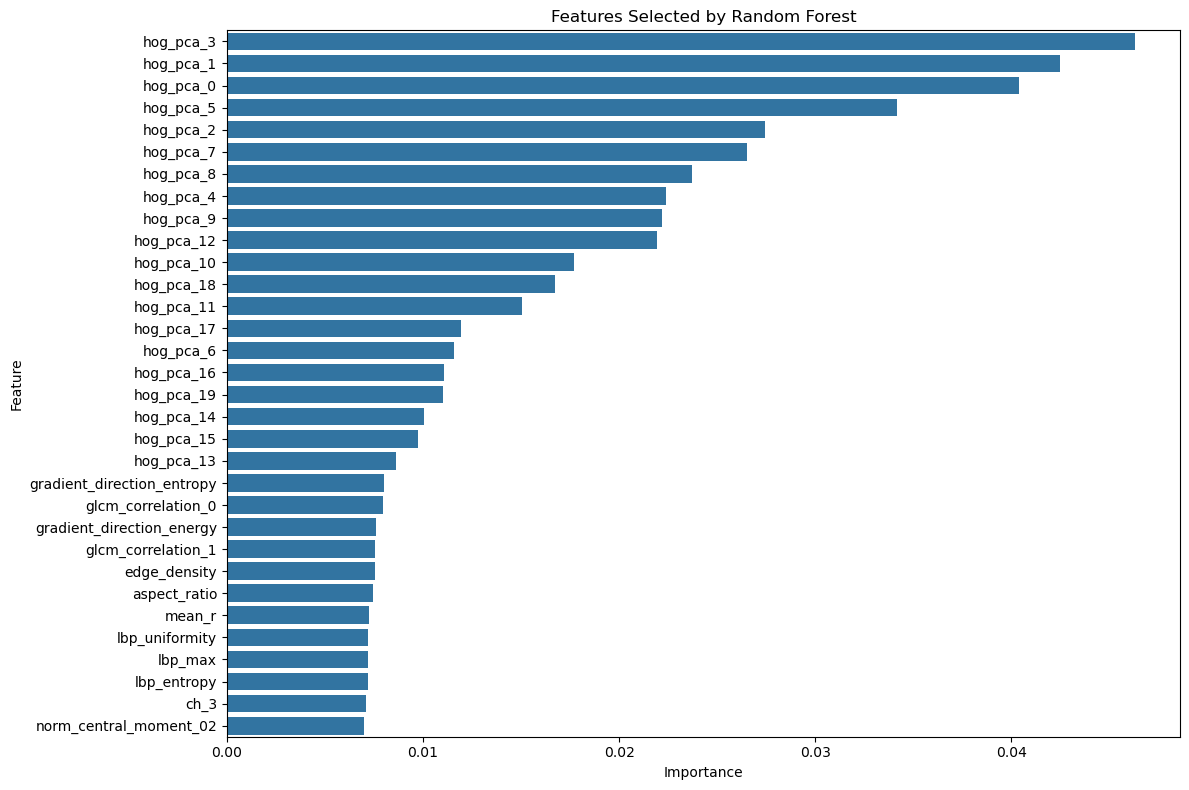

In [43]:
select_features('rf')

['mean_b',
 'mean_r',
 'hog_pca_0',
 'ch_33',
 'hog_pca_2',
 'hog_pca_3',
 'ch_65',
 'hog_pca_7',
 'ch_31',
 'hog_pca_8',
 'ch_95',
 'hog_pca_4',
 'hog_pca_1',
 'hog_pca_12',
 'lbp_entropy',
 'ch_34',
 'gradient_mean_magnitude',
 'glcm_contrast_1',
 'lbp_max',
 'hog_pca_9',
 'hog_pca_5',
 'extent',
 'ch_32',
 'ch_63',
 'ch_66',
 'glcm_contrast_0',
 'ch_6',
 'ch_1',
 'circularity',
 'glcm_correlation_0',
 'ch_4',
 'ch_7',
 'ch_67',
 'hog_pca_6',
 'hog_pca_14',
 'ch_3',
 'ch_25',
 'ch_5',
 'ch_40',
 'hog_pca_11',
 'ch_76',
 'ch_38',
 'ch_35',
 'ch_91',
 'ch_68',
 'ch_28',
 'ch_47',
 'ch_30',
 'ch_18',
 'convexity',
 'hog_pca_18',
 'ch_78',
 'ch_20',
 'hog_pca_17',
 'ch_44',
 'hog_pca_15',
 'ch_10',
 'ch_51',
 'aspect_ratio',
 'ch_12',
 'ch_41',
 'ch_56',
 'ch_23',
 'ch_55',
 'ch_17',
 'ch_46',
 'ch_43',
 'ch_22',
 'ch_61',
 'ch_26',
 'ch_45',
 'gradient_direction_energy',
 'ch_84',
 'ch_82',
 'norm_central_moment_20',
 'ch_48',
 'ch_94',
 'edge_density',
 'ch_9',
 'hog_pca_10',
 'ch_42',

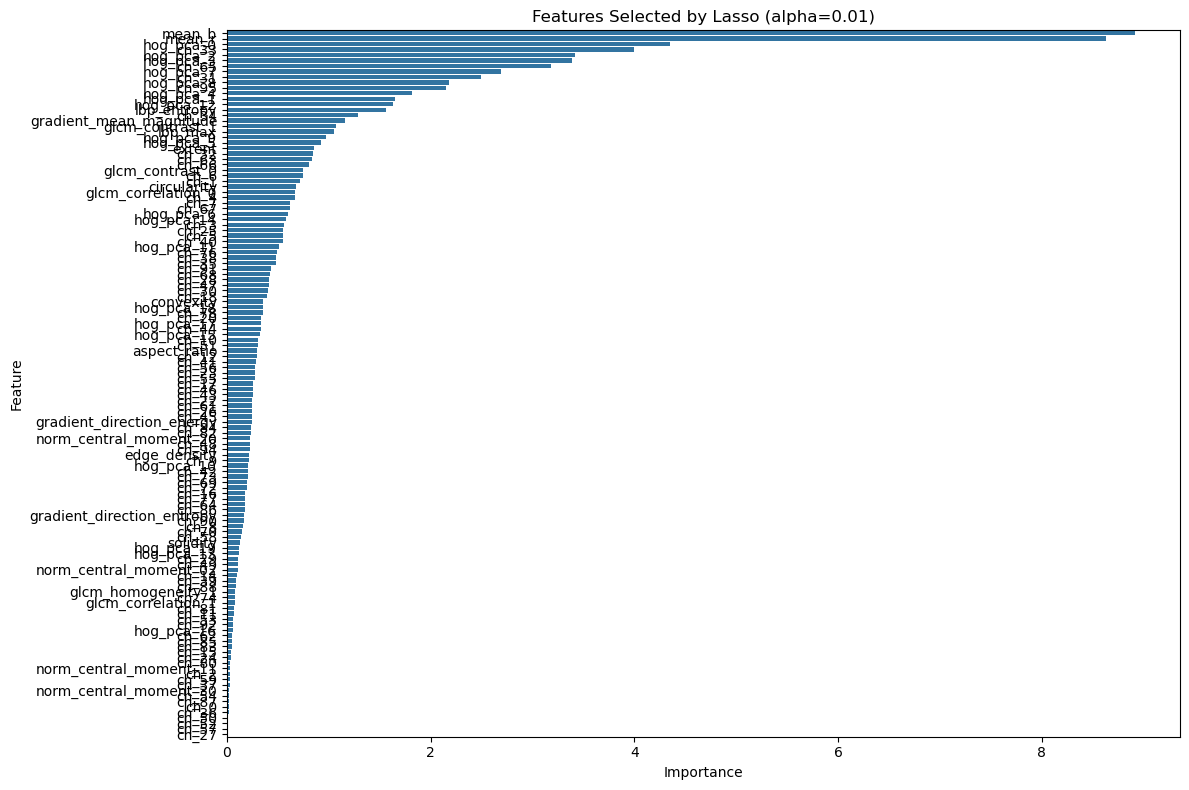

In [44]:
select_features('lasso')

['circularity',
 'aspect_ratio',
 'solidity',
 'extent',
 'norm_central_moment_20',
 'norm_central_moment_02',
 'norm_central_moment_30',
 'glcm_contrast_0',
 'glcm_contrast_1',
 'glcm_homogeneity_0',
 'glcm_homogeneity_1',
 'glcm_energy_0',
 'glcm_energy_1',
 'gradient_mean_magnitude',
 'gradient_std_magnitude',
 'hog_pca_0',
 'hog_pca_1',
 'hog_pca_2',
 'hog_pca_3',
 'hog_pca_4',
 'hog_pca_5',
 'hog_pca_6',
 'hog_pca_7',
 'hog_pca_8',
 'hog_pca_9',
 'hog_pca_10',
 'hog_pca_11',
 'hog_pca_12',
 'hog_pca_17',
 'hog_pca_18',
 'hog_pca_19',
 'ch_12',
 'ch_20',
 'ch_27',
 'ch_28',
 'ch_44',
 'ch_45',
 'ch_46',
 'ch_47',
 'ch_59',
 'ch_63',
 'ch_88',
 'ch_90',
 'ch_92',
 'ch_94',
 'ch_95',
 'edge_density',
 'mean_b',
 'mean_g',
 'mean_r']

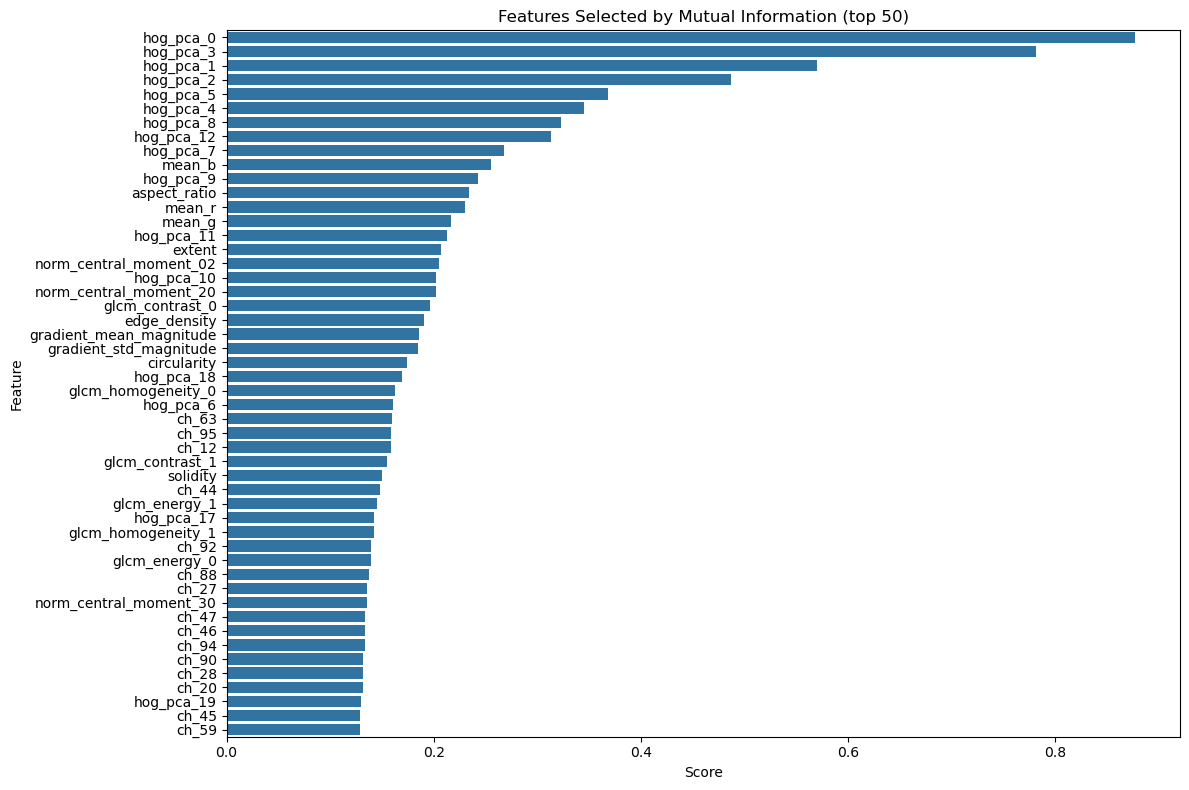

In [45]:
select_features('mi')